# import

In [1]:
import gc
import os
import re
import sys
import time
import warnings

import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score)
from sklearn.model_selection import StratifiedKFold, train_test_split
from torch import nn, optim
from torch.utils.checkpoint import checkpoint
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import AutoConfig, AutoModel, AutoTokenizer

In [2]:
pd.set_option("display.max_column", 100)
pd.set_option("display.max_row", 100)

# パラメータの設定

In [3]:
# パラメータの設定
MODELNAME="bert-base-uncased"
config = AutoConfig.from_pretrained(MODELNAME).to_dict()
config["drop_rate"] = 0.4
config["output_size"] = 3
config["train_batch_size"] = 150
config["valid_batch_size"] = 50
config["num_epochs"] = 3
config["learning_rate"] = 1e-4
config["model_name"] = MODELNAME
config["max_token_len"] = 128
config["fold_split"] = 5
config["gradient_checkpoint"] = True
config["freezing"] = True
config["header_type"] = "Linear"

# データの読み込み

In [4]:
df = pd.read_csv(
    "/home/jovyan/work/data/train.csv",
    index_col="discourse_id",
)

## データのラベル定義

In [5]:
discourse_types = ["Lead", "Position", "Claim", "Evidence", "Counterclaim", "Concluding Statement", "Rebuttal"]
target_col_names = ["Adequate", "Effective", "Ineffective"]

## データ整形

In [6]:
#下処理:discourse_typeとdiscourse_textを結合する
sep = AutoTokenizer.from_pretrained(config["model_name"]).sep_token
df["inputs"] = df.discourse_type + sep + df.discourse_text

In [7]:
# データの分割
df_train_valid, df_test = train_test_split(
    df, test_size=0.2, shuffle=True, random_state=0, stratify=df["discourse_effectiveness"]
)

## tokenizer, Dataset, BERTClassの定義

In [8]:
#textをtokenizeするクラス(前処理)
class tokenize(object):
    def __init__(self, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __call__(self, text):
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True
        )
        input_ids = inputs["input_ids"]
        attention_mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"]

        return {
            "input_ids": torch.LongTensor(input_ids),
            "attention_mask": torch.LongTensor(attention_mask),
            "token_type_ids": torch.LongTensor(token_type_ids),
        }

In [9]:
# Datasetの定義
class CreateDataset(Dataset):
    def __init__(self, X, y, transform):
        self.X = X
        self.y = y
        self.transform=transform
    def __len__(self):  # len(Dataset)で返す値を指定
        return len(self.y)

    def __getitem__(self, index):  # Dataset[index]で返す値を指定
        text = self.X[index]
        output_dict = self.transform(text)
        output_dict["labels"] = torch.Tensor(self.y[index])
        return output_dict

In [10]:
# Subsetの定義
class CreateSubset(Dataset):
    def __init__(self, X, y, transform, indices):
        self.X = X
        self.y = y
        self.indices = indices
        self.transform = transform

    def __len__(self):  # len(Dataset)で返す値を指定
        return len(self.indices)

    def __getitem__(self, idx):  # Dataset[index]で返す値を指定
        _X = self.X[self.indices[idx]]
        output_dict = self.transform(_X)
        output_dict["labels"] = torch.Tensor(self.y[self.indices[idx]])
        return output_dict

In [11]:
def freeze(module):
    for parameter in module.parameters():
        parameter.require_grad = False

In [12]:
# BERT分類モデル
class BERTClass(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.bert = AutoModel.from_pretrained(
            self.config["model_name"], output_hidden_states=True
        )
        self.drop = nn.Dropout(self.config["drop_rate"])
        self.fc = nn.Linear(self.config["hidden_size"], self.config["output_size"])
        # Gradient Checkpointing
        if self.config["gradient_checkpoint"]:
            self.bert.gradient_checkpointing_enable()
        # Freeze
        if self.config["freezing"]:
            freeze(self.bert.embeddings)
            freeze(self.bert.encoder.layer[:2])

    def forward(self, input_ids, attention_mask, token_type_ids):
        if self.config["header_type"] == "Linear":
            out = self.bert(
                input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids
            )
            out = self.drop(out.hidden_states[-1])
            out = self.fc(out[:, 0, :])
            return out

In [13]:
# BERT分類モデルの定義(Pooling)
class BERTPoolingClass(BERTClass):
    def __init__(self, config):
        super().__init__(config)
        self.drop = nn.Dropout(self.config["drop_rate"])
        self.drop = nn.Dropout(self.config["drop_rate"])
        self.pooling = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(
            self.config["hidden_size"], self.config["output_size"]
        )

    def forward(self, input_ids, attention_mask, token_type_ids):
        out = self.bert(
            input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids
        )
        out = self.drop(out.hidden_states[-1])
        out, _ = out.max(1)
        out = self.fc(out)
        return out

In [14]:
# BERT分類モデルの定義(Couvolution)
class BERTConvolutionClass(BERTClass):
    def __init__(self, config):
        super().__init__(config)
        self.drop = nn.Dropout(self.config["drop_rate"])
        self.cnn1 = nn.Conv1d(
            self.config["hidden_size"], 256, kernel_size=2, padding=1
        )
        self.cnn2 = nn.Conv1d(256, 1, kernel_size=2, padding=1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        out = (
            self.bert(
                input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids
            )
            .hidden_states[-1]
            .permute(0, 2, 1)
        )
        out = nn.functional.relu(self.cnn1(out))
        out = self.cnn2(out)
        out, _ = torch.max(out, 2)
        return out

In [15]:
# BERT分類モデルの定義(Concatenate)
class BERTConcatenateClass(BERTClass):
    def __init__(self, config):
        super().__init__(config)
        self.drop = nn.Dropout(self.config["drop_rate"])
        self.fc = nn.Linear(
            self.config["hidden_size"] * 4, self.config["output_size"]
        )

    def forward(self, input_ids, attention_mask, token_type_ids):
        out = self.bert(
            input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids
        )
        out = torch.cat(
            [out["hidden_states"][-1 * i][:, 0] for i in range(1, 4 + 1)], dim=1
        )  # concatenate
        out = self.fc(out)

        return out

In [16]:
def calculate_loss_f1(model, criterion, loader, device):
    """損失・正解率を計算"""
    model.eval()
    loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for data in loader:
            # デバイスの指定
            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)
            token_type_ids = data["token_type_ids"].to(device)
            labels = data["labels"].to(device)

            # 順伝播
            outputs = model(input_ids, attention_mask, token_type_ids)

            # 損失計算
            loss += criterion(outputs, labels).item()

            # 確率計算
            prob = torch.sigmoid(outputs)
            pred = torch.where(prob > 0.5, 1, 0)

            # f1スコア計算
            f1 = f1_score(pred.cpu().numpy(), labels.cpu().numpy(), average="macro", zero_division=0)

    return loss / len(loader), f1

In [17]:
# EralyStopクラス
class EarlyStopping:
    def __init__(
        self,
        patience=3,
        threshold=0.1,
        verbose=False,
        path="/home/jovyan/work/data/checkpoint/checkpoint_model.pth",
    ):
        """引数：最小値の非更新数カウンタ、最小値判定の閾値, 表示設定、モデル格納path"""

        self.patience = patience  # 設定ストップカウンタ
        self.threshold = threshold  # 最小値判定の閾値。比率で指定
        self.verbose = verbose  # 表示の有無
        self.counter = 0  # 現在のカウンタ値
        self.early_stop = False  # ストップフラグ
        self.val_loss_min = np.Inf  # 前回のベストスコア記憶用
        self.path = path  # ベストモデル格納path

    def __call__(self, val_loss, model):
        if val_loss > (1 - self.threshold) * self.val_loss_min:  # ベストスコアを更新できなかった場合
            self.counter += 1  # ストップカウンタを+1
            if self.verbose:  # 表示を有効にした場合は経過を表示
                print(
                    f"EarlyStopping counter: {self.counter} out of {self.patience}"
                )  # 現在のカウンタを表示する
            if self.counter >= self.patience:  # 設定カウントを上回ったらストップフラグをTrueに変更
                self.early_stop = True

        else:  # ベストスコアを更新した場合
            if self.verbose:  # 表示を有効にした場合は、前回のベストスコアからどれだけ更新したか？を表示
                print(
                    f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ..."
                )
            torch.save(model.state_dict(), self.path)  # ベストモデルを指定したpathに保存

            self.val_loss_min = val_loss
            self.counter = 0  # ストップカウンタリセット

In [18]:
def train_model(
    X_train_valid,
    y_train_valid,
    model,
    criterion,
    optimizer,
    config,
    device=None,
):
    """モデルの学習を実行し、損失・正解率のログを返す"""
    # デバイスの指定
    model.to(device)

    # tokenizerの作成
    tokenizer = tokenize(
        AutoTokenizer.from_pretrained(config["model_name"]), config["max_token_len"]
    )

    torch.backends.cudnn.benchmark = True

    # 学習
    log_train = []
    log_valid = []

    # Stratified K foldの作成
    skf = StratifiedKFold(n_splits=config["fold_split"], random_state=None)
    folds = [
        (_train_index, _valid_index)
        for _train_index, _valid_index in skf.split(X_train_valid, y_train_valid)
    ]

    # 正解ラベルのone-hot化
    y_train_valid = pd.get_dummies(y_train_valid).to_numpy()

    earlystopping = EarlyStopping(patience=5, threshold=0.005, verbose=True)
    for epoch_num in range(config["num_epochs"]):
        # 開始時刻の記録
        s_time = time.time()

        # Kfoldsの選択
        train_index, valid_index = folds[epoch_num % config["fold_split"]]

        # dataloaderの作成
        dataset_train = CreateSubset(
            X_train_valid, y_train_valid, tokenizer, train_index
        )
        dataloader_train = DataLoader(
            dataset_train,
            batch_size=config["train_batch_size"],
            shuffle=True,
            num_workers=2,
            pin_memory=True,
        )
        dataset_valid = CreateSubset(
            X_train_valid, y_train_valid, tokenizer, valid_index
        )
        dataloader_valid = DataLoader(
            dataset_valid,
            batch_size=config["valid_batch_size"],
            shuffle=False,
            num_workers=2,
            pin_memory=True,
        )

        # 訓練モードに設定
        model.train()

        # Automatic Mixed Precision
        scaler = torch.cuda.amp.GradScaler()

        for data in tqdm(dataloader_train, leave=False):
            # デバイスの指定
            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)
            token_type_ids = data["token_type_ids"].to(device)
            labels = data["labels"].to(device)

            # 勾配をゼロで初期化
            optimizer.zero_grad()

            # 順伝播 + 誤差逆伝播 + 重み更新
            with torch.cuda.amp.autocast():
                outputs = model(input_ids, attention_mask, token_type_ids)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            torch.cuda.empty_cache()

            # 損失と正解率の算出
            loss_train, f1_train = calculate_loss_f1(
                model, criterion, dataloader_train, device
            )
            loss_valid, f1_valid = calculate_loss_f1(
                model, criterion, dataloader_valid, device
            )
            log_train.append([loss_train, f1_train])
            log_valid.append([loss_valid, f1_valid])

            # 終了時刻の記録
            e_time = time.time()
            
            # 毎エポックearlystoppingの判定をさせる
            if epoch_num > 0:
                earlystopping(loss_valid, model)  # callメソッド呼び出し
                if earlystopping.early_stop:  # ストップフラグがTrueの場合、breakでforループを抜ける
                    print("Early Stopping!")
                    break

        # ログを出力
        print(
            f"epoch: {epoch_num + 1}, loss_train: {loss_train:.4f}, loss_valid: {loss_valid:.4f}, {(e_time - s_time):.4f}sec"
        )
        if epoch_num > 0:
            if earlystopping.early_stop:
                break
    return {"train": log_train, "valid": log_valid}

In [19]:
# モデルの定義
model = BERTClass(config)

# 損失関数の定義
criterion = torch.nn.BCEWithLogitsLoss()

# オプティマイザの定義
optimizer = torch.optim.AdamW(params=model.parameters(), lr=config["learning_rate"])

# デバイスの指定
device = torch.device("cuda:0")

# モデルの学習
log = train_model(
    df_train_valid["discourse_text"],
    df_train_valid["discourse_effectiveness"],
    model,
    criterion,
    optimizer,
    config,
    device=device,
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


epoch: 1, loss_train: 0.3928, loss_valid: 0.4490, 37370.2761sec


  0%|          | 0/157 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.387782).  Saving model ...


  1%|          | 1/157 [03:59<10:23:08, 239.67s/it]

Validation loss decreased (0.387782 --> 0.384293).  Saving model ...


  1%|▏         | 2/157 [07:47<10:00:33, 232.47s/it]

Validation loss decreased (0.384293 --> 0.380625).  Saving model ...


  2%|▏         | 3/157 [11:54<10:13:56, 239.20s/it]

Validation loss decreased (0.380625 --> 0.374717).  Saving model ...


  3%|▎         | 4/157 [16:04<10:20:43, 243.42s/it]

Validation loss decreased (0.374717 --> 0.369754).  Saving model ...


  3%|▎         | 5/157 [19:51<10:01:46, 237.54s/it]

Validation loss decreased (0.369754 --> 0.365597).  Saving model ...


  4%|▍         | 6/157 [23:41<9:51:37, 235.08s/it] 

Validation loss decreased (0.365597 --> 0.360826).  Saving model ...


  5%|▌         | 8/157 [31:29<9:39:19, 233.28s/it]

EarlyStopping counter: 1 out of 5
Validation loss decreased (0.360826 --> 0.355525).  Saving model ...


  6%|▋         | 10/157 [39:36<9:45:02, 238.79s/it]

EarlyStopping counter: 1 out of 5


  7%|▋         | 11/157 [43:17<9:27:57, 233.41s/it]

EarlyStopping counter: 2 out of 5
Validation loss decreased (0.355525 --> 0.350393).  Saving model ...


  8%|▊         | 13/157 [50:48<9:08:46, 228.65s/it]

EarlyStopping counter: 1 out of 5
Validation loss decreased (0.350393 --> 0.346549).  Saving model ...


 10%|▉         | 15/157 [58:23<9:00:26, 228.36s/it]

EarlyStopping counter: 1 out of 5


 10%|█         | 16/157 [1:02:04<8:51:41, 226.25s/it]

EarlyStopping counter: 2 out of 5


 11%|█         | 17/157 [1:06:05<8:58:30, 230.79s/it]

EarlyStopping counter: 3 out of 5


 11%|█▏        | 18/157 [1:10:14<9:07:19, 236.25s/it]

EarlyStopping counter: 4 out of 5


EarlyStopping counter: 5 out of 5
Early Stopping!
epoch: 2, loss_train: 0.3685, loss_valid: 0.3502, 4461.4479sec


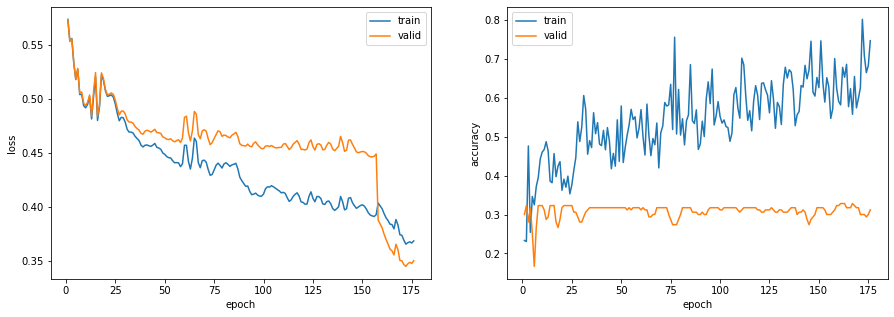

In [20]:
# ログの可視化
x_axis = [x for x in range(1, len(log["train"]) + 1)]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(x_axis, np.array(log["train"]).T[0], label="train")
ax[0].plot(x_axis, np.array(log["valid"]).T[0], label="valid")
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("loss")
ax[0].legend()
ax[1].plot(x_axis, np.array(log["train"]).T[1], label="train")
ax[1].plot(x_axis, np.array(log["valid"]).T[1], label="valid")
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("accuracy")
ax[1].legend()
plt.show()

In [21]:
# Datasetの作成
tokenizer = tokenize(AutoTokenizer.from_pretrained(config["model_name"]), config["max_token_len"])
y_test = pd.get_dummies(df_test["discourse_effectiveness"]).to_numpy()
dataset_test = CreateDataset(df_test["discourse_text"], y_test, tokenizer)

In [22]:
def prediction(model, dataset, device):
    # Dataloaderの作成
    loader = DataLoader(dataset, batch_size=100, shuffle=False)

    model.eval()
  
    prob = []
    pred = []
    label = []
    with torch.no_grad():
        for data in loader:
            # デバイスの指定
            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)
            token_type_ids = data["token_type_ids"].to(device)
            label.append(data["labels"].to(device))

            # 順伝播 + 予測値の取得 
            outputs = model.forward(input_ids, attention_mask, token_type_ids)
            prob.append(torch.sigmoid(outputs))
            pred.append(torch.where(outputs>0.5, 1, 0))
            
        pred = torch.cat(pred, dim=0)
        prob = torch.cat(prob, dim=0)
        label = torch.cat(label, dim=0)
        
        del model, loader
        gc.collect()
        return pred, label, prob

In [23]:
y_pred, y_label, y_prob = prediction(model, dataset_test, device)

In [24]:
#precision, recallの算出
def calculate_pr_rc(pred, label):
    pr_rc = []
    for col in pred.columns:
        pr = precision_score(pred.loc[:, col].values, label.loc[:, col].values)
        rc = recall_score(pred.loc[:, col].values, label.loc[:, col].values)
        pr_rc.append([pr, rc])
    return pr_rc

In [25]:
precision_score(y_pred.to('cpu').numpy(), y_label.to('cpu').numpy(), average="macro")

0.4627313307027628

In [26]:
recall_score(y_pred.to('cpu').numpy(), y_label.to('cpu').numpy(), average="macro")

0.6645365842609475

In [27]:
def calc_cross_entropy(y_prob, y_label):
    loss = -1 * np.mean(np.sum( y_label * np.log(y_prob), axis=1))
    return loss

In [31]:
calc_cross_entropy(y_prob.to('cpu').numpy(), y_label.to('cpu').numpy())

0.7613557577133179

In [32]:
torch.save(model.state_dict(), "/home/jovyan/work/data/checkpoint/checkpoint_model_.pth")

In [33]:
def plot_performance(performances):
    plt.rcParams["font.size"] = 16
    
    length = len(performances.columns)
    
    plt.figure(figsize=(25, 10))
    left = np.arange(length)
    
    plt.bar(left - 0.2, performances.loc["precision", :], width=0.4, label="precision")
    plt.bar(left + 0.2, performances.loc["recall", :], width=0.4, label="recall")
    plt.xticks(np.arange(length), performances.columns.tolist(), rotation=90)
    plt.yticks(np.arange(11)*0.1, np.round(np.arange(11)*0.1, 1))
    plt.grid(axis="y")
    plt.title("precision  vs recall ")
    plt.legend(loc="upper left")
    plt.show()

In [34]:
plot_performance(test_pr_rc)

NameError: name 'test_pr_rc' is not defined